In [18]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [19]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics

K.clear_session()

# input image dimensions
img_rows, img_cols, img_chns = 64, 160, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 30
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
    
latent_dim = 50
intermediate_dim = 128
epsilon_std = 1.0
epochs = 150

train_dir = "chairs/train"
val_dir = "chairs/val"

In [20]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 32 * 80, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 32, 80)
else:
    output_shape = (batch_size, 32, 80, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, img_rows + 1, img_cols + 1)
else:
    output_shape = (batch_size, img_rows + 1, img_cols + 1, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 160, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 160, 1)   5           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 80, 64)   320         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 80, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

F:\Anaconda\envs\py35\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Output "conv2d_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_5" during training.


In [21]:
from PIL import Image
import glob
import os

def read_images_from_dir(directory):
    image_list = []
    for filename in glob.glob(directory + os.sep + '*.png'):
        im = np.array(Image.open(filename))
        im = im / 255;
        image_list.append(im)
        
    return np.array(image_list)

In [45]:
x_train = read_images_from_dir(train_dir)
x_val = read_images_from_dir(val_dir)

x_train = x_train[:200]

x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_val = x_val.reshape((x_val.shape[0],) + original_img_size)

(200, 64, 160, 1)


In [23]:
from keras.callbacks import TensorBoard

In [24]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, None),
        callbacks=[TensorBoard(log_dir='logs')])

Train on 766 samples, validate on 93 samples
Epoch 1/50
766/766 [==============================] - 77s 101ms/step - loss: 19757.7906 - val_loss: 4078.7877
Epoch 2/50
766/766 [==============================] - 76s 99ms/step - loss: 4276.5471 - val_loss: 3800.9956
Epoch 3/50
766/766 [==============================] - 77s 101ms/step - loss: 4284.4141 - val_loss: 3839.3847
Epoch 4/50
766/766 [==============================] - 79s 103ms/step - loss: 4127.5022 - val_loss: 4216.9876
Epoch 5/50
766/766 [==============================] - 74s 96ms/step - loss: 4058.2924 - val_loss: 4214.2267
Epoch 6/50
766/766 [==============================] - 79s 103ms/step - loss: 3799.9460 - val_loss: 3821.4583
Epoch 7/50
766/766 [==============================] - 79s 103ms/step - loss: 3590.8492 - val_loss: 3316.1368
Epoch 8/50
766/766 [==============================] - 75s 98ms/step - loss: 3424.1412 - val_loss: 3327.0014
Epoch 9/50
766/766 [==============================] - 72s 94ms/step - loss: 3321.1361

In [25]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

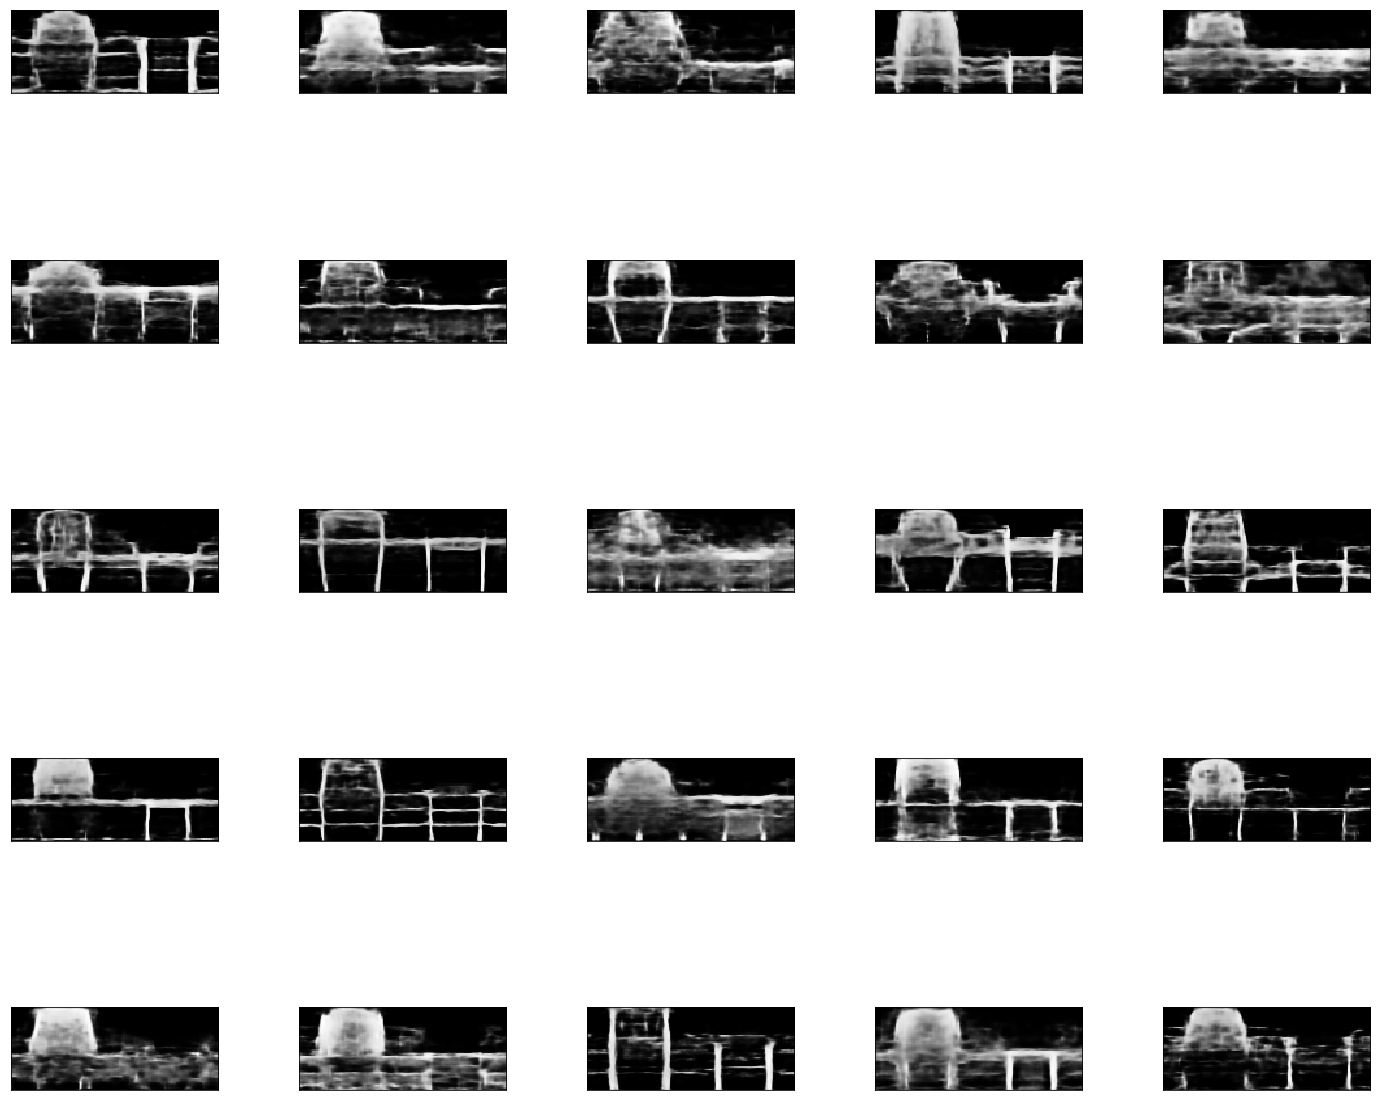

In [43]:
import matplotlib.gridspec as gridspec

def create_image_from_latent_point(pt):
    z_sample = np.array([pt])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
    x_decoded = generator.predict(z_sample, batch_size=batch_size)
    return x_decoded[0].reshape(img_rows, img_cols)

def create_point_in_latent_space(ndim):
    coordinates = np.random.uniform(0.05, 0.95, ndim)
    return norm.ppf(coordinates)

def create_image_grid(n, m):
    gs = gridspec.GridSpec(n, m, top=1., bottom=0., right=1., left=0., hspace=2, wspace=0.)
    
    for g in gs:
        pt = create_point_in_latent_space(latent_dim)
        img = create_image_from_latent_point(pt)
        
        ax = plt.subplot(g)
        ax.imshow(img, cmap='Greys_r')
        ax.set_xticks([])
        ax.set_yticks([])

        
plt.figure(figsize=(20, 15))
create_image_grid(5, 5)
plt.show()